# ML Test: Modelos Predictivos de Clasificación Binaria de Clic sobre anuncio mediante técnicas de Aprendizaje Supervisado

Diego F. Osorio 

Machine Learning Engineer
MSc in Electronics and Computer Science (AI)

**Universidad de los Andes**

* Introducción
* Exploración
* ML Pipelines
* Evaluación
* Predicciones
* Conclusiones

# Librerias

In [38]:
# general
import numpy as np
import pandas as pd
import re
import os
import joblib
import pandas as pd
import random

# funciones
from funciones.data_exploration import explore
from funciones.feature_cleaning import missing_data, outlier, rare_values
from funciones.feature_cleaning import missing_data as ms
from funciones.feature_cleaning import outlier as ot
from funciones.feature_cleaning import rare_values as ra
from funciones.feature_engineering import discretization, encoding, transformation
from funciones.feature_selection import embedded_method, feature_shuffle, filter_method, hybrid


# visualización
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import warn
from pandas.plotting import scatter_matrix
plt.style.use('seaborn-colorblind')
#from data_exploration import explore


# preprocesamiento
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif,chi2
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE


# ML
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error
import pylab
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix


# ML pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel


from sklearn import set_config



C:\Users\Diego\AppData\Local\Temp\ipykernel_18360\2505579995.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


# Generar Base de datos

In [2]:
# Number of samples
n_samples = 1000

# Generate the sample data
data = {
    'copy': [random.choice(["50% off!", "Buy now!", "Limited offer!", "Best in town!", "Hurry up!", "Don't miss out!"]) for _ in range(n_samples)],
    'audience': [random.choice(["teens", "adults", "parents", "students", "elderly"]) for _ in range(n_samples)],
    'keywords': [random.choice(["sale", "discount", "offer", "limited", "exclusive", "bestseller"]) for _ in range(n_samples)],
    'time_of_day': [random.choice([i for i in range(24)]) for _ in range(n_samples)],  # 0 to 23 representing hours
    'clicked': [random.choice([0, 1]) for _ in range(n_samples)]
}

# Convert dictionary to DataFrame
df = pd.DataFrame(data)

# Add some intentional patterns
for i in range(n_samples):
    if df.at[i, 'audience'] == 'elderly' and df.at[i, 'copy'] == "Hurry up!":
        df.at[i, 'clicked'] = 0  # Elderly audience might not respond well to a 'Hurry up!' message
    
    if df.at[i, 'time_of_day'] >= 6 and df.at[i, 'time_of_day'] <= 11 and df.at[i, 'keywords'] == 'sale':
        df.at[i, 'clicked'] = 1  # More people might click on 'sale' keyword ads in the morning hours

# Save the dataset to a CSV file
df.to_csv("data/ad_data.csv", index=False)

df

,copy,audience,keywords,time_of_day,clicked
0,Hurry up!,teens,bestseller,2,1
1,Buy now!,students,sale,21,0
2,Don't miss out!,students,sale,14,1
3,Limited offer!,adults,discount,14,1
4,Limited offer!,students,limited,18,1
...,...,...,...,...,...
995,50% off!,adults,offer,18,0
996,Best in town!,teens,sale,16,1
997,Best in town!,elderly,limited,7,1
998,Buy now!,adults,offer,6,1


# Modelo Base: XGBoost default

In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

data = pd.read_csv("data/ad_data.csv")

X = data.drop('clicked', axis=1)
y = data['clicked']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Explicación del Error

El error en el código se debe a que se está intentado entrenar el modelo de ML XGBoost con variables (columnas) categóricas que todavía no se han preprocesado (codificado), por lo que el modelo no puede entrenarse correctamente. A continuación, se presenta el código corregido

In [5]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

data = pd.read_csv("data/ad_data.csv")

X = data.drop('clicked', axis=1)
y = data['clicked']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# codificar variables en datos de entrenamiento y prueba
# codificación one-hot [0-1] para poder procesar las variables categóricas
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")


Accuracy: 0.59


# Preprocesamiento

In [40]:
# crear copia de base de datos sin preprocesar
data_copy = df.copy(deep=True)
data_copy

,copy,audience,keywords,time_of_day,clicked
0,Hurry up!,teens,bestseller,2,1
1,Buy now!,students,sale,21,0
2,Don't miss out!,students,sale,14,1
3,Limited offer!,adults,discount,14,1
4,Limited offer!,students,limited,18,1
...,...,...,...,...,...
995,50% off!,adults,offer,18,0
996,Best in town!,teens,sale,16,1
997,Best in town!,elderly,limited,7,1
998,Buy now!,adults,offer,6,1


## Limpieza de datos

In [56]:
# calcular porcentaje de NAs y NULLs en cada columna
porcentaje_missing = df.isna().mean() * 100
porcentaje_null = df.isna().mean() * 100

# Sort the variables by missing percentage in descending order
porcentaje_missing.sort_values(ascending=False, inplace=True)
porcentaje_null.sort_values(ascending=False, inplace=True)

# ver the variables with missing percentage
print('porcentaje missing NA',porcentaje_missing)
print('porcentaje NULL NULL',porcentaje_null)

# no hay NA/NULL en base de datos

porcentaje missing NA time_of_day             0.0
clicked                 0.0
copy_Best in town!      0.0
copy_Buy now!           0.0
copy_Don't miss out!    0.0
copy_Hurry up!          0.0
copy_Limited offer!     0.0
audience_elderly        0.0
audience_parents        0.0
audience_students       0.0
audience_teens          0.0
keywords_discount       0.0
keywords_exclusive      0.0
keywords_limited        0.0
keywords_offer          0.0
keywords_sale           0.0
dtype: float64
porcentaje NULL NULL time_of_day             0.0
clicked                 0.0
copy_Best in town!      0.0
copy_Buy now!           0.0
copy_Don't miss out!    0.0
copy_Hurry up!          0.0
copy_Limited offer!     0.0
audience_elderly        0.0
audience_parents        0.0
audience_students       0.0
audience_teens          0.0
keywords_discount       0.0
keywords_exclusive      0.0
keywords_limited        0.0
keywords_offer          0.0
keywords_sale           0.0
dtype: float64


## Codificación

In [60]:
# one-hot encoding
df = pd.get_dummies(df, drop_first=True)
df


,time_of_day,clicked,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale
0,2,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0
1,21,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
2,14,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1
3,14,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,18,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,18,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
996,16,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1
997,7,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0
998,6,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0


## Separar x variables, y dependiente

In [61]:
# definir variables
x = df.drop(columns='clicked')
y = df['clicked'] # y dependiente (class)
x

,time_of_day,copy_Best in town!,copy_Buy now!,copy_Don't miss out!,copy_Hurry up!,copy_Limited offer!,audience_elderly,audience_parents,audience_students,audience_teens,keywords_discount,keywords_exclusive,keywords_limited,keywords_offer,keywords_sale
0,2,0,0,0,1,0,0,0,0,1,0,0,0,0,0
1,21,0,1,0,0,0,0,0,1,0,0,0,0,0,1
2,14,0,0,1,0,0,0,0,1,0,0,0,0,0,1
3,14,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,18,0,0,0,0,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,18,0,0,0,0,0,0,0,0,0,0,0,0,1,0
996,16,1,0,0,0,0,0,0,0,1,0,0,0,0,1
997,7,1,0,0,0,0,1,0,0,0,0,0,1,0,0
998,6,0,1,0,0,0,0,0,0,0,0,0,0,1,0


## Tratamiento de datos desbalanceados

c:\Users\Diego\anaconda3\Lib\site-packages\imblearn\over_sampling\_smote\base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


1    0.5
0    0.5
Name: clicked, dtype: float64

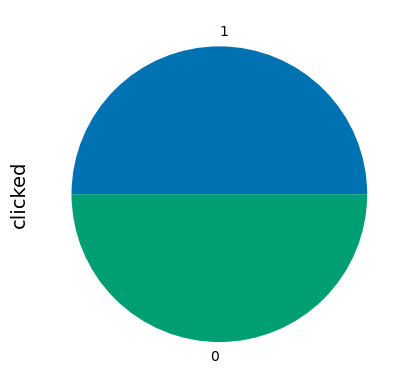

In [62]:
# crear nueva base
# SMOTE() crear clase que hacer oversampling
sm = SMOTE(sampling_strategy='auto', random_state=1, k_neighbors=5, n_jobs=-1)

# crear nueva base con oversampling 
x, y = sm.fit_resample(x, y)
x = pd.DataFrame(x, columns = x.columns)

# value_counts().plot(kind='pie'):  hacer conteo de clases y plot tipo 'pie'
y.value_counts().plot(kind='pie')
y.value_counts(normalize=True)

# Exploración

* Análisis Descriptivo
* Análisis Estadístico
* Visualización
* Técnicas de correlación
* Aprendizaje no Supervisado

## Análisis Descriptivo

In [7]:
df 

,copy,audience,keywords,time_of_day,clicked
0,Hurry up!,teens,bestseller,2,1
1,Buy now!,students,sale,21,0
2,Don't miss out!,students,sale,14,1
3,Limited offer!,adults,discount,14,1
4,Limited offer!,students,limited,18,1
...,...,...,...,...,...
995,50% off!,adults,offer,18,0
996,Best in town!,teens,sale,16,1
997,Best in town!,elderly,limited,7,1
998,Buy now!,adults,offer,6,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   copy         1000 non-null   object
 1   audience     1000 non-null   object
 2   keywords     1000 non-null   object
 3   time_of_day  1000 non-null   int64 
 4   clicked      1000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 39.2+ KB


In [9]:
# contar observaciones(fila) por clase de variable
df["clicked"].value_counts()

1    508
0    492
Name: clicked, dtype: int64

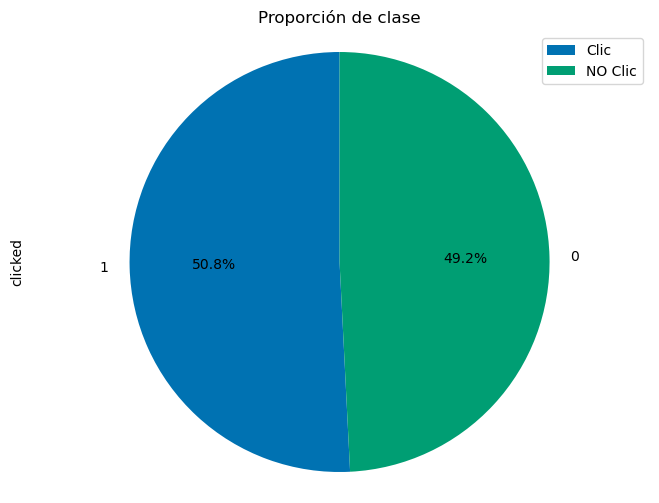

In [10]:
# calcular proporcion de clase

# variable y dependiente
df["clicked"].value_counts()
# calcular proporcion de clases
class_proportions = df["clicked"].value_counts(normalize=True)

# crear pie plot
plt.figure(figsize=(8, 6))
class_proportions.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Proporción de clase')
plt.legend(labels=['Clic','NO Clic'], loc='best')
plt.axis('equal')

# Show the plot
plt.show()

1    0.508
0    0.492
Name: clicked, dtype: float64

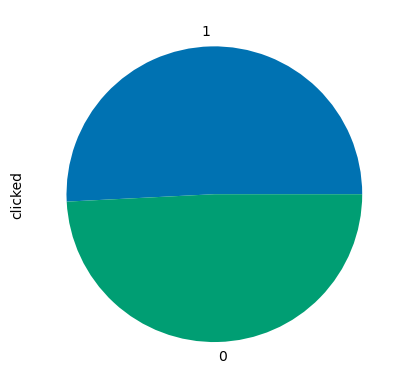

In [11]:
# distribucion de clases
# 1=clic, 0=no clic
df["clicked"].value_counts().plot(kind='pie')
df["clicked"].value_counts(normalize=True)

In [12]:
# análisis estadístico preliminar para variables numéricas
# contar observaciones(filas) por variable
# promedio, desviacion estandar
# valor máximo, mínnimo y cuantiles por columna (variable)

df.describe()

,time_of_day,clicked
count,1000.000000,1000.000000
mean,11.232000,0.508000
std,6.775994,0.500186
min,0.000000,0.000000
25%,5.000000,0.000000
50%,11.000000,1.000000
75%,17.000000,1.000000
max,23.000000,1.000000


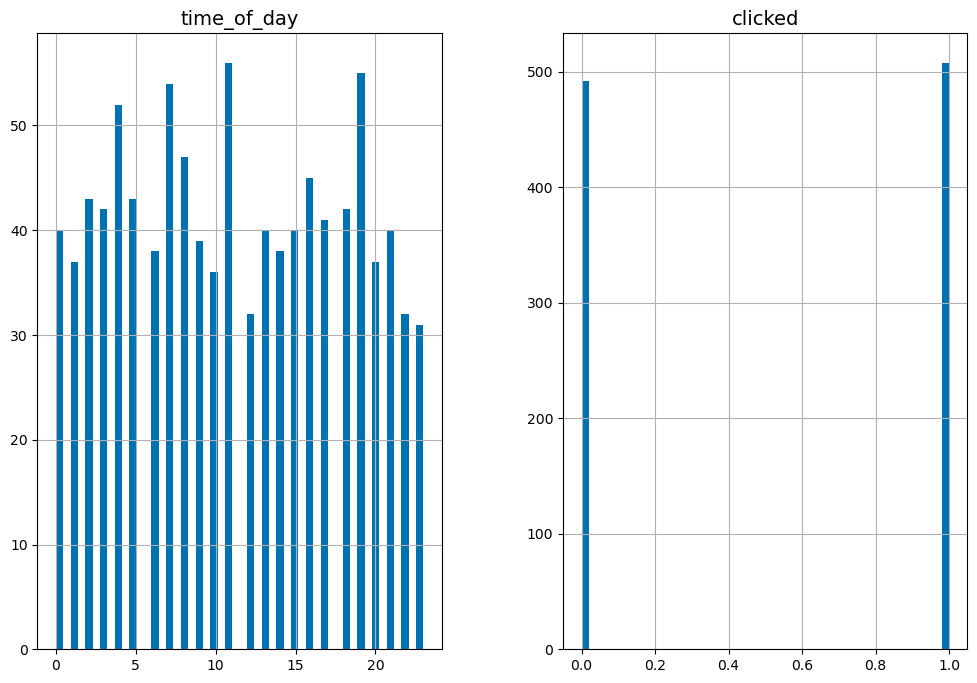

In [13]:
# Plot hisogramas de distrubucion de variables numéricas en base de datos
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(12, 8))
plt.show()


## Análisis Estadístico

## Visualización

Image saved at ./data/Barplot_audience_clicked.png


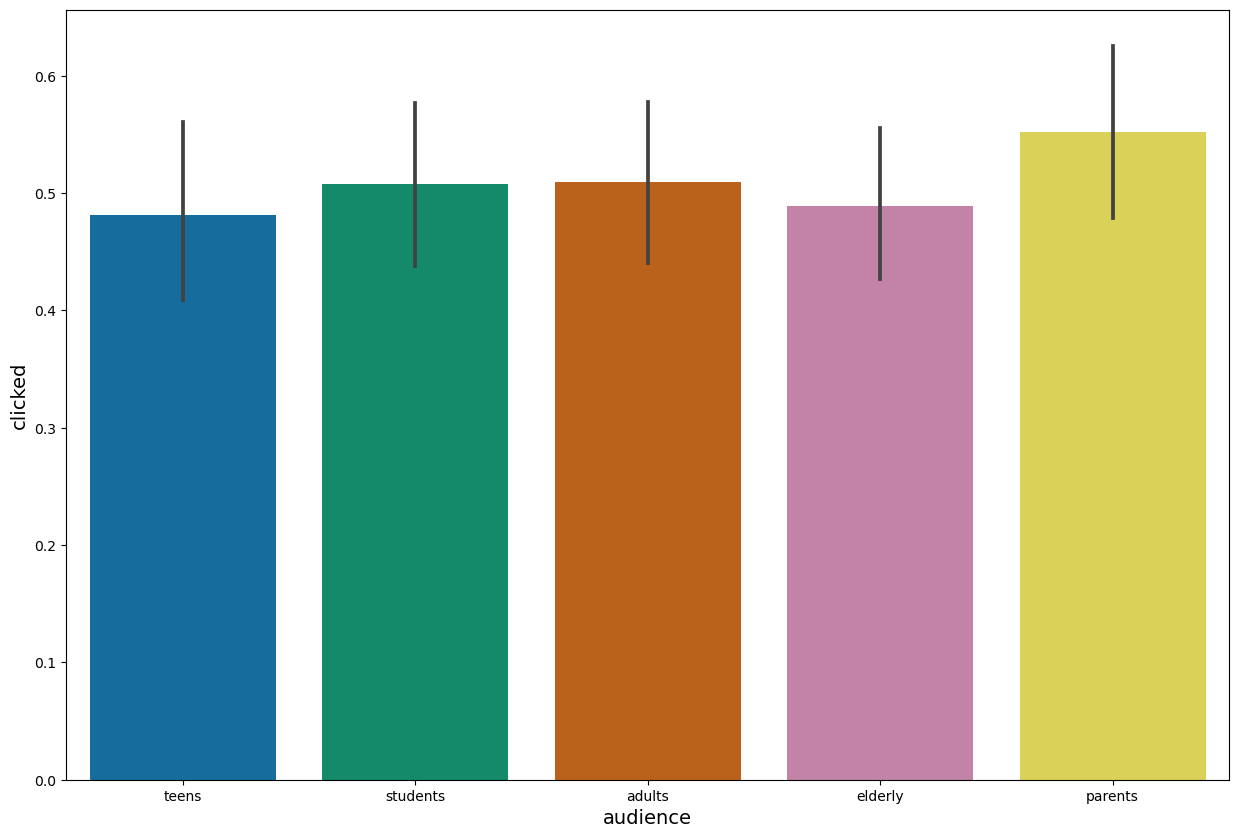

In [14]:
# gráfico de barra 
# y target (clic) vs. x clase
explore.discrete_var_barplot(x='audience',y='clicked',data=df,output_path='./data/')

Image saved at ./data\Countplot_clicked.png


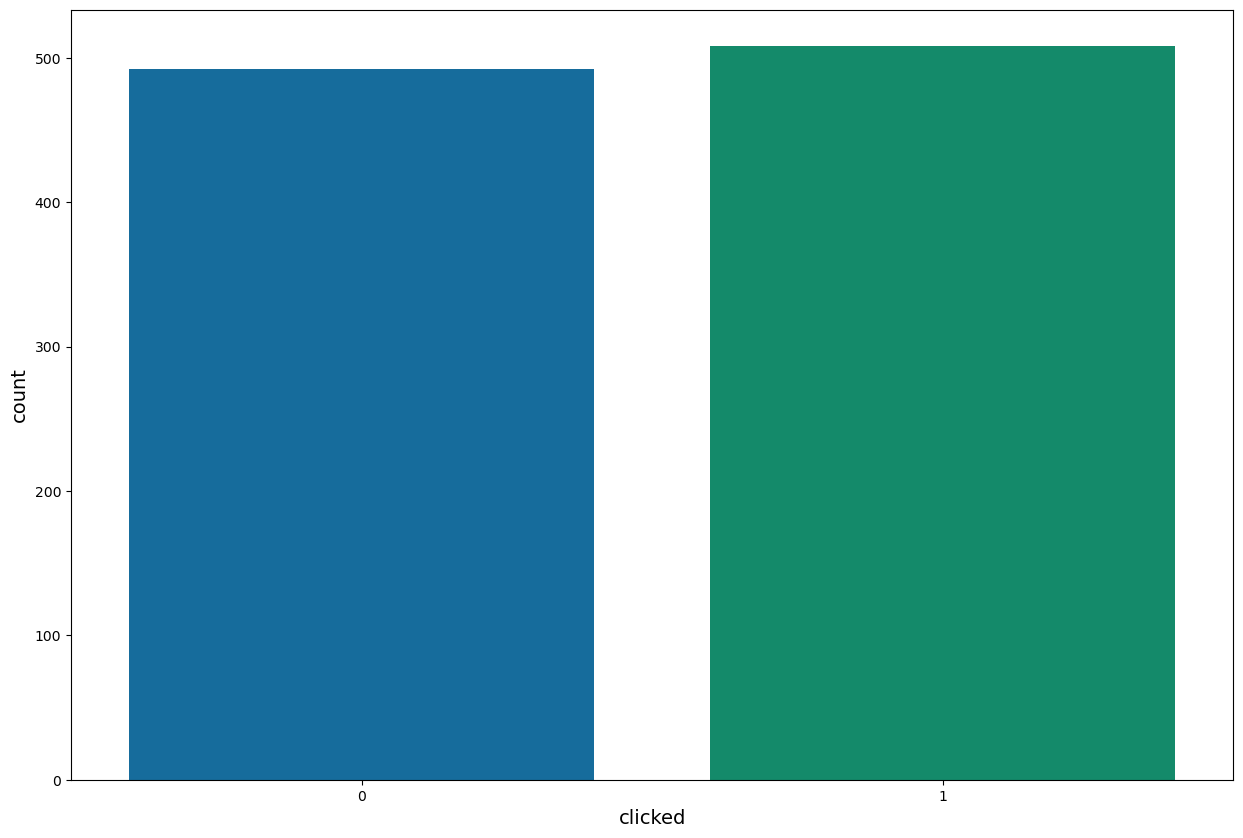

In [15]:
# count plot: contar observaciones por categoria en columna 
# x= 'clicked'
explore.discrete_var_countplot(x='clicked',data=df,output_path='./data')

Image saved at ./data\Boxplot_audience_clicked.png


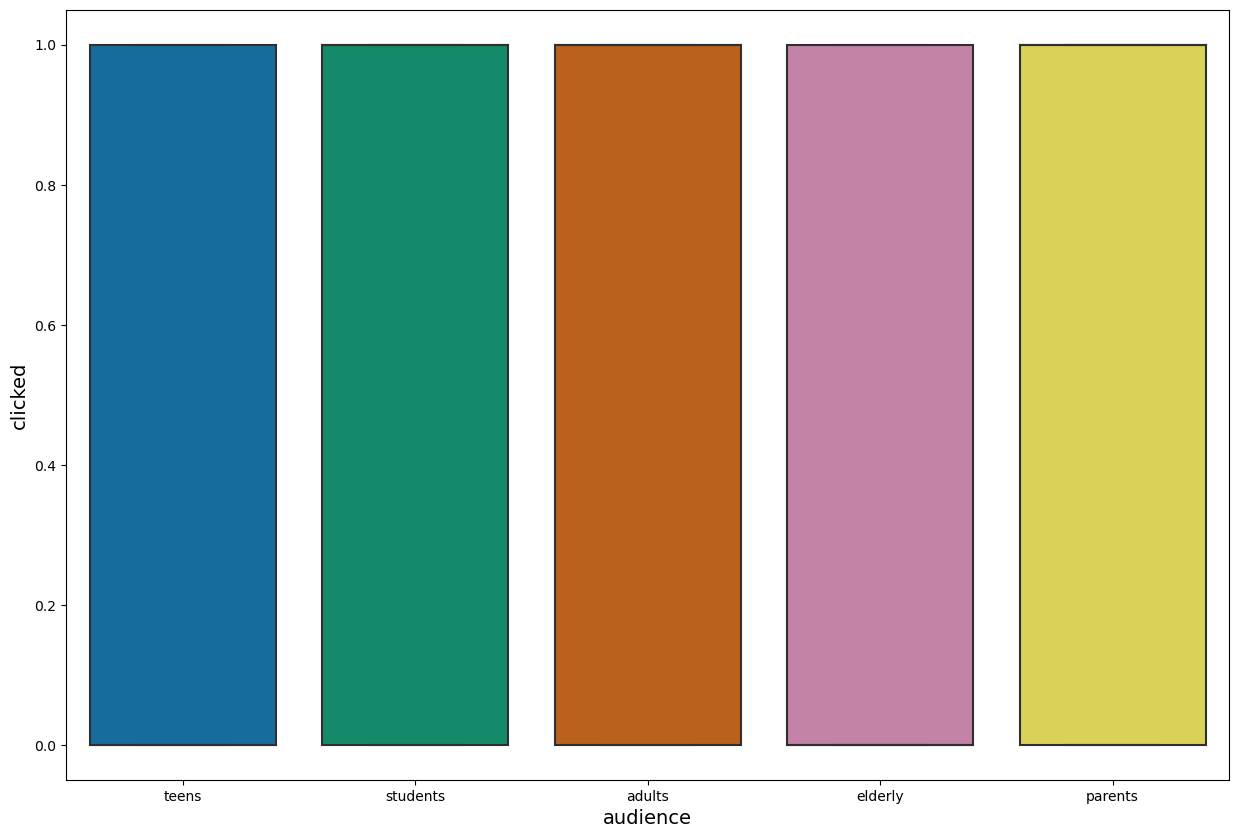

In [16]:
# box plot 
# y Fare vs. x clase
explore.discrete_var_boxplot(x='audience',y='clicked',data=df,output_path='./data')

## Técnicas de Correlación

In [17]:
# crear matriz de correlación entre variables numericas en base de datos 
corr_matrix = df.corr()
corr_matrix

C:\Users\Diego\AppData\Local\Temp\ipykernel_18360\1766072850.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


,time_of_day,clicked
time_of_day,1.000000,0.001519
clicked,0.001519,1.000000


In [18]:
# correlación con 'variable ' especifica target
corr_matrix["clicked"].sort_values(ascending=False)

clicked        1.000000
time_of_day    0.001519
Name: clicked, dtype: float64

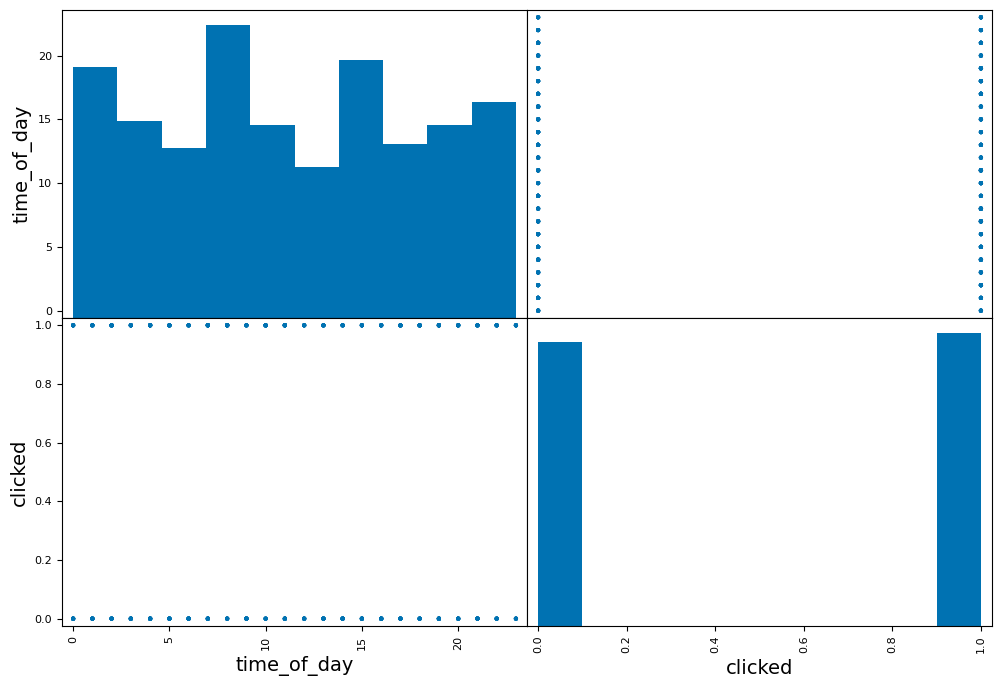

In [19]:
# Plot matriz de dispersion entre variables numéricas
# variables numericas: "time_of_day", "clicked"
attributes = ["time_of_day", "clicked"]
scatter_matrix(df[attributes], figsize=(12, 8))
plt.show()


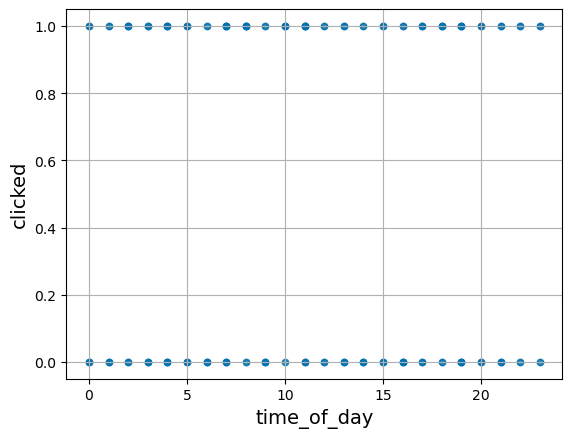

In [20]:
# gráfico de dispersión entre variables numéricas
df.plot(kind="scatter", x="time_of_day", y="clicked",
             alpha=0.1, grid=True)
plt.show()

c:\Users\Diego\OneDrive\Documents\GitHub\tech_skills\auxiliar\funciones\data_exploration\explore.py:179: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = data.corr()


Image saved at ./data/Corr_plot.png


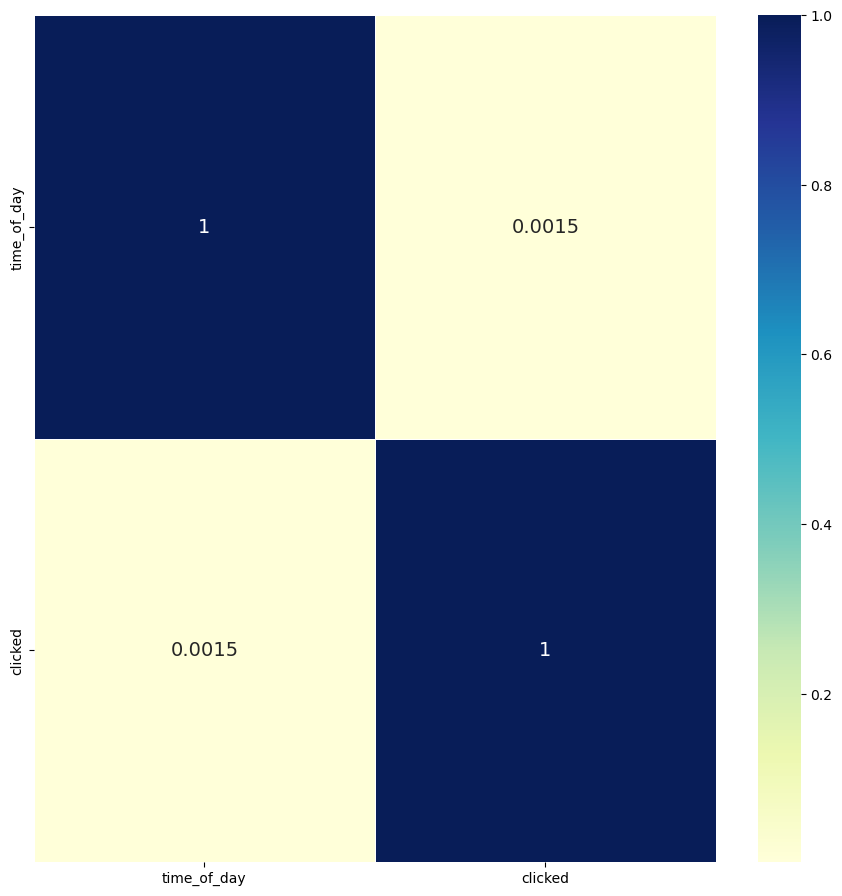

In [21]:
# gráfico de correlación entre columnas (variables) de DataFrame
explore.correlation_plot(data=df,output_path='./data/')


# ML Pipelines

In [22]:
# copiar base de datos
data_copy = df.copy(deep=True)
data_copy


,copy,audience,keywords,time_of_day,clicked
0,Hurry up!,teens,bestseller,2,1
1,Buy now!,students,sale,21,0
2,Don't miss out!,students,sale,14,1
3,Limited offer!,adults,discount,14,1
4,Limited offer!,students,limited,18,1
...,...,...,...,...,...
995,50% off!,adults,offer,18,0
996,Best in town!,teens,sale,16,1
997,Best in town!,elderly,limited,7,1
998,Buy now!,adults,offer,6,1


## Separar x variables, y target (dependiente)

In [23]:
# definir variables
x = data_copy.drop(columns='clicked')
y = data_copy['clicked'] # y dependiente (class)



## Separar base de datos en datos de entrenamiento y datos de prueba

In [24]:
# dividir base de datos en datos de entrenamiento y datos de prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
x_train

,copy,audience,keywords,time_of_day
382,Limited offer!,adults,offer,20
994,Best in town!,adults,limited,20
982,50% off!,parents,discount,13
47,Hurry up!,elderly,discount,9
521,Don't miss out!,parents,sale,14
...,...,...,...,...
767,50% off!,adults,bestseller,11
72,Hurry up!,parents,limited,1
908,50% off!,students,exclusive,13
235,Buy now!,adults,discount,20


## ML Pipelines

In [25]:
# extraer nombres de columnas por tipo 
# retorna tupla de listas con nombres de columnas por tipo

def columns_types(data):
    
    # definir estrucutra de datos por tipo de variable
    numeric_types=['int', 'int32', 'int64', 'float', 'float32', 'float64']
    category_types = ['object','category']
    str_types = ['string']
    bool_types = ['bool']
    date_types = ['datetime64', 'datetime', 'datetime64[ns]']
    
    # listas de nombres de variables
    numeric_columns = []
    str_columns = []
    bool_columns = []
    date_columns = []
    category_columns = []

    for column in data.columns:
        
        col_type = str(data[column].dtype)
        
        if any(col_type.startswith(t) for t in numeric_types) or any(col_type.startswith(t) for t in numeric_types):
            numeric_columns.append(column)
        elif any(col_type.startswith(t) for t in str_types):
            str_columns.append(column)
        elif any(col_type.startswith(t) for t in bool_types):
            bool_columns.append(column)
        elif any(col_type.startswith(t) for t in date_types):
            date_columns.append(column)
        elif any(col_type.startswith(t) for t in category_types):
            category_columns.append(column)
            

    return numeric_columns, category_columns, str_columns,bool_columns, date_columns


In [26]:
# extraer nombres de columnas por tipo 
numeric_columns, category_columns, str_columns,bool_columns, date_columns = columns_types(x)
numeric_columns, category_columns, str_columns,bool_columns, date_columns


(['time_of_day'], ['copy', 'audience', 'keywords'], [], [], [])

In [27]:
# crear pipeline para variables numericas
# imputador simple por promedio
# escalador estandar 
num_pipeline = make_pipeline(
  SimpleImputer(strategy="mean"),
  StandardScaler())

# crear pipeline para variables categiricas
# imputador simple por moda
# codificador one-hot [0-1]
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))


In [28]:
# crear ML pipeline 
# variables numéricas: num_pipeline
# variables categóricas: cat_pipeline
preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)


In [29]:
# crear pipeline end-to-end
# Clasificación (y dependiente: )
# ML pipeline preprocesamiento + random_forest
full_pipeline1 = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestClassifier(random_state=1, n_jobs=-1)),
])

# crear grid de hiper parametros de modelo
param_grid = [
    {'random_forest__n_estimators': [50, 100, 200],
      'random_forest__max_features' : ['sqrt','log2',3,5],
      'random_forest__max_depth' : [2,3,5],
      'random_forest__max_features' : ['sqrt','log2',3,5]
    },
    
    {'random_forest__n_estimators': [200, 300, 150],
      'random_forest__max_features' : [3,5,7],
      'random_forest__max_depth' : [2,3,5],
      'random_forest__max_features' : ['sqrt',3,5]
    }
    
]

# ver lista de parámetros
# pipeline__param 
params_list = list(full_pipeline1.get_params().keys() )
params_list

# GridSearchCV: sintonizador de hiper parametros
# parametros: ML pipeline, grid de hiper parametros, particiones (cv)
# scoring: metrica de evaluación a optimizar
grid_search = GridSearchCV(full_pipeline1, param_grid, cv=5,
                           scoring='recall')

# sintonizar GridSearchCV con datos de entrenamiento
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000026AA930A850>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy...
                                       ('random_forest',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=1))]),
             param_grid=[{'random_forest__max_depth': [2, 3, 5],
                          'random_forest__max_features': ['sqrt', 'log2', 3, 5],
                          'random_forest__n_estimators': [50, 100, 200]},
                         {'random_forest__max_depth': [2, 3, 5],
                          'random_forest__max_features': ['sqrt', 3, 5],
                          'random_forest__n_estimators': [200, 300, 150]}],
             scoring='recall')

In [30]:
# mejores hiper parametros
grid_search.best_params_

{'random_forest__max_depth': 2,
 'random_forest__max_features': 3,
 'random_forest__n_estimators': 100}

In [31]:
# mejor ML pipeline1
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026AA5649B50>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026AA51EB550>)])),
                ('random_forest',
                 RandomForestClassifier(max_depth=2, max_features=3, n_jobs=-1,
                                        random_state=1))])

In [32]:
# ver resultados de validación cruzada
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__max_depth,param_random_forest__max_features,param_random_forest__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,0.336600,0.093791,0.090601,0.027695,2,3,100,"{'random_forest__max_depth': 2, 'random_forest...",0.829268,0.855422,0.722892,0.759036,0.819277,0.797179,0.048752,1
41,0.374201,0.026194,0.088599,0.005816,2,3,150,"{'random_forest__max_depth': 2, 'random_forest...",0.792683,0.831325,0.722892,0.771084,0.831325,0.789862,0.040704,2
39,0.530602,0.065967,0.134400,0.030839,2,3,200,"{'random_forest__max_depth': 2, 'random_forest...",0.731707,0.807229,0.710843,0.795181,0.831325,0.775257,0.046062,3
8,0.680600,0.243556,0.146803,0.056475,2,3,200,"{'random_forest__max_depth': 2, 'random_forest...",0.731707,0.807229,0.710843,0.795181,0.831325,0.775257,0.046062,3
6,0.138604,0.001856,0.039201,0.002228,2,3,50,"{'random_forest__max_depth': 2, 'random_forest...",0.719512,0.807229,0.698795,0.795181,0.819277,0.767999,0.049086,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0.427680,0.006030,0.098803,0.003127,5,5,200,"{'random_forest__max_depth': 5, 'random_forest...",0.597561,0.614458,0.602410,0.578313,0.650602,0.608669,0.023983,59
33,0.165003,0.012602,0.043399,0.002245,5,5,50,"{'random_forest__max_depth': 5, 'random_forest...",0.597561,0.614458,0.602410,0.602410,0.626506,0.608669,0.010521,59
35,0.498422,0.064332,0.118602,0.021399,5,5,200,"{'random_forest__max_depth': 5, 'random_forest...",0.597561,0.614458,0.602410,0.578313,0.650602,0.608669,0.023983,59
24,0.338002,0.045052,0.155400,0.124990,5,sqrt,50,"{'random_forest__max_depth': 5, 'random_forest...",0.548780,0.626506,0.638554,0.518072,0.626506,0.591684,0.048747,62


## Evaluación de Modelo

In [33]:
# extraer mejor modelo de ML pipeline
final_model = grid_search.best_estimator_  # incluye preprocesamiento

# importancia de variables (interpretacion de modelo)
feature_importances = final_model["random_forest"].feature_importances_

# extraer importancia de variables 
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(0.20938914946112044, 'pipeline-2__keywords_sale'),
 (0.1672655121151905, 'pipeline-1__time_of_day'),
 (0.054567240228645376, 'pipeline-2__keywords_offer'),
 (0.05284430373356594, 'pipeline-2__audience_adults'),
 (0.051480878180247706, 'pipeline-2__copy_Hurry up!'),
 (0.0498950429496499, 'pipeline-2__copy_Best in town!'),
 (0.04702723861549482, 'pipeline-2__audience_elderly'),
 (0.045165525065012674, 'pipeline-2__keywords_limited'),
 (0.043862436717841166, 'pipeline-2__keywords_bestseller'),
 (0.039264260856499, 'pipeline-2__keywords_exclusive'),
 (0.03781682628431585, 'pipeline-2__keywords_discount'),
 (0.0333524284484973, "pipeline-2__copy_Don't miss out!"),
 (0.03335203150092663, 'pipeline-2__audience_teens'),
 (0.03229940357730321, 'pipeline-2__audience_parents'),
 (0.03151815323702095, 'pipeline-2__copy_Limited offer!'),
 (0.028162066655413785, 'pipeline-2__audience_students'),
 (0.021559675233954537, 'pipeline-2__copy_50% off!'),
 (0.021177827139300262, 'pipeline-2__copy_Buy now

In [34]:
# generar predicciones
y_pred = cross_val_predict(final_model, x_test, y_test, cv=3)


# métrica de evaluación 'recall'
# validación cruzada: cv=5
cross_val_score(final_model, x_test, y_test, cv=5, scoring="recall")

# matriz de confusión
cm = confusion_matrix(y_test, y_pred)
cm



array([[84, 22],
       [65, 29]], dtype=int64)